[0.22512116 0.96940383 1.3346491  1.63739986 1.98396996 2.18549681
 2.32764497 2.47500644 2.71448908 2.90162368 3.09101644 3.28301651
 3.4935281  3.70585534 3.90090159 4.08672711 4.30529427 4.49553791
 4.66445248 4.83642394 5.00722157 5.1522219  5.2937978  5.45993766
 5.5891746  5.72595123 5.82401162 5.93286561 6.0303782  6.10857694
 6.19508876 6.2751511  6.34774312 6.40526894 6.47163333 6.53052698
 6.58698601 6.63782695 6.67984254 6.72460078 6.75967709 6.80359808
 6.84016773 6.87532843 6.90482897 6.93846291 6.95548139 6.97813894
 6.99418436 7.01477893 7.02456572 7.03774569 7.06077029 7.08051916
 7.09417436 7.10885023 7.12023382 7.13414083 7.14370738 7.15112171
 7.16531059 7.16806406 7.1890322  7.18942154 7.18392699 7.18883899
 7.19868925 7.20686249 7.20261753 7.21777662 7.2216903  7.22258447
 7.23019983 7.22405823 7.22884742 7.2335757  7.24126202 7.24353757
 7.24173543 7.24595569 7.24495593 7.2458757  7.2519659  7.2515805
 7.25403335 7.26070759 7.26564926 7.25694746 7.26506843 7.26385

Text(0, 0.5, 'entropy')

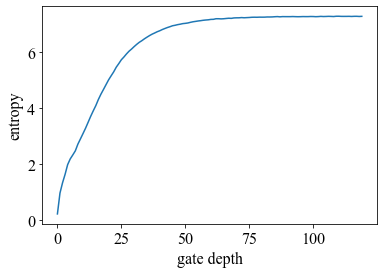

In [47]:
import numpy as np
from scipy import linalg 
import matplotlib.pyplot as plt


a, b, c = 1*np.pi/5, np.pi/3, np.pi/5
X = np.matrix(np.array([[0.,1.],[1.,0.]]))
Z = np.matrix(np.array([[1.,0.],[0.,-1.]]))
U_R_matrix = linalg.expm(- 1j * (b * X + c * Z))
U_XX_matrix = linalg.expm(- 1j * a * np.kron(X,X)).reshape([2,2,2,2])

class Reg: 
    def __init__(self,n):
        self.n=n
        self.psi=np.zeros((2,)*n) 
        self.psi[(0,)*n]=1
        
def U_R(i,reg): 
    reg.psi=np.tensordot(U_R_matrix,reg.psi,(1,i)) 
    reg.psi=np.moveaxis(reg.psi,0,i)

def U_XX(control, target, reg):
    reg.psi=np.tensordot(U_XX_matrix, reg.psi, ((2,3),(control, target))) 
    reg.psi=np.moveaxis(reg.psi,(0,1),(control,target))

def compute_entanglement(reg):
    rho_A = np.tensordot(reg.psi.conj(), reg.psi, (np.arange(0,L//2), np.arange(0,L//2)))
    rho_A = rho_A.reshape([2**(L//2), 2**(L//2)])
   
    lam, v = np.linalg.eig(rho_A)
    lam = np.real(lam)+10**(-12)
    return -np.dot(lam, np.log(lam))/np.log(2.)

H_matrix=1/np.sqrt(2)*np.array([[1, 1],
                                [1,-1]])

CNOT_matrix=np.array([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]]).reshape([2,2,2,2])

def H(i,reg): 
    reg.psi=np.tensordot(H_matrix,reg.psi,(1,i)) 
    reg.psi=np.moveaxis(reg.psi,0,i)

def CNOT(control, target, reg):
    reg.psi=np.tensordot(CNOT_tensor, reg.psi, ((2,3),(control, target))) 
    reg.psi=np.moveaxis(reg.psi,(0,1),(control,target))   

def generate_GHZ(reg): 
    H(0,reg)
    for i in range(reg.n-1):
        CNOT(i,i+1,reg)
    
# Example of final usage: create uniform superposition
L = 16
N_layers = 120

# reinitialize register
reg=Reg(L)

# apply N_layers layers of qubit rotations and XX gates
S = np.zeros(N_layers)

for i in range(N_layers):
    
    #apply rotation layer
    for j in range(L):
        U_R(j, reg)
    
    #apply entangling layer on odd bonds
    for j in range(L // 2):
        U_XX(2*j, 2*j+1, reg)
        
    #apply entangling layer on even bonds
    for j in range(1,L // 2):
        U_XX(2*j-1, 2*j, reg)
        
    # compute entanglement
    S[i] = compute_entanglement(reg)
    

print(S)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"
fig, ax = plt.subplots()

plt.plot(np.arange(0,N_layers), S)
plt.xlabel('gate depth')
plt.ylabel('entropy')

